# Datojen haku ja esikäsittely

In [1]:
from set_path import set_path
mainpath, path = set_path('areadata')

In [2]:
from read_and_prepare_data import read_and_prepare_data
stat, post, kunta_stat, vaalidata = read_and_prepare_data(path)

read_and_prepare_data  read from start
read_post_muncipalities  read from file
read_stats_postcode  read from file
read_ravintolat_ja_kaupat  read from file
read_kiinteisto  read from file
read_vaalit  read from file


In [3]:
from selected_cols import selected_cols
numeric_features, categorical_features = selected_cols(largeset=False, parties=True)

In [4]:
from sklearn.feature_selection import  mutual_info_classif
import pandas as pd
import numpy as np
from draw_and_create_clusters import create_kmeans_clusters 

from prepare_and_scale_data import prepare_and_scale_data
from create_prediction import select_kbest
from select_columns_and_clean_data import select_columns_and_clean_data
from draw_all import draw_features
from create_dbscan_clusters import create_dbscan_clusters


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.options.display.max_colwidth = 100


#valitaan käsittelyyn tuleva alue 91 = Helsinki
selected = stat[(stat['muncipality_code']==91) | (stat['muncipality_code']==92) | (stat['muncipality_code']==49) | (stat['muncipality_code']==235)].copy()
selected_vaalidata = vaalidata[(vaalidata['Kuntanumero']==91) | (vaalidata['Kuntanumero']==92) | (vaalidata['Kuntanumero']==49) | (vaalidata['Kuntanumero']==235) ].copy()
post_included = post[(post['muncipality_code']==91) | (post['muncipality_code']==92) | (post['muncipality_code']==49) | (post['muncipality_code']==235)]['postcode'].copy()

#valitaan käsittelyyn tuleva alue FI1B1 = Uusimaa
selected = stat[stat['area_code']=='FI1B1'].copy()
selected_vaalidata = vaalidata[vaalidata['area_code']=='FI1B1'].copy()
post_included = post[post['area_code']=='FI1B1'].copy()


selected = stat.copy()
selected_vaalidata = vaalidata.copy()
post_included = post.copy()



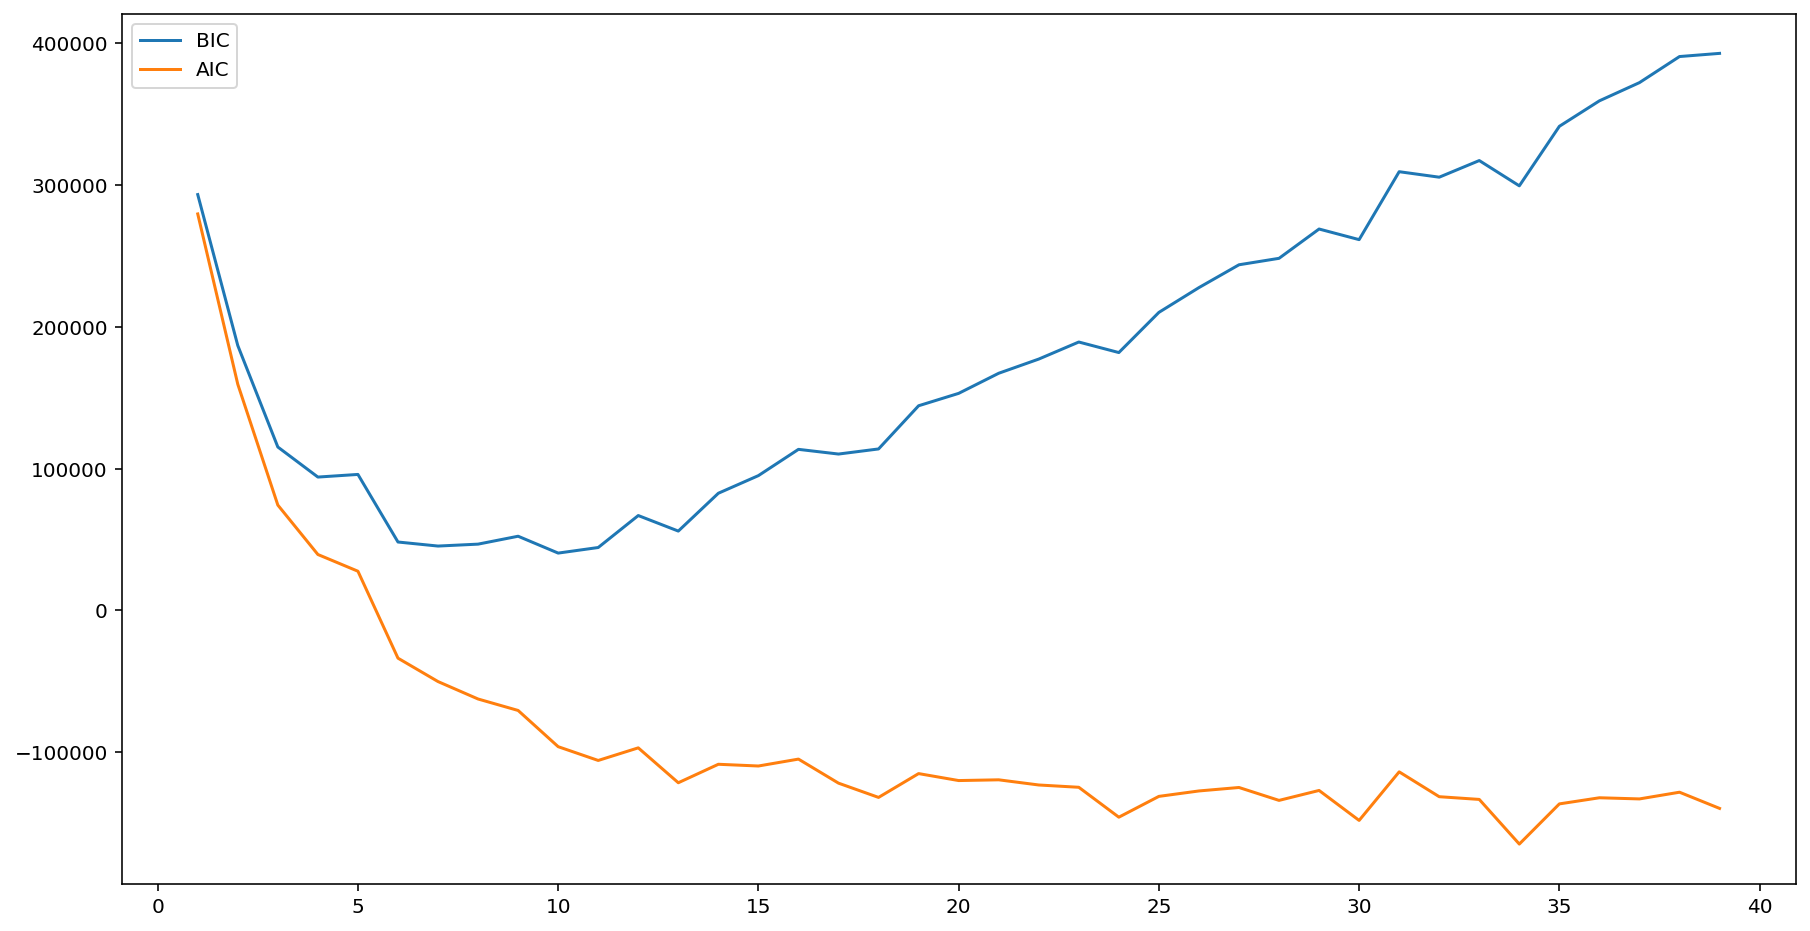

In [5]:
from gaussian_model import create_and_draw_best_gaussian_mix

data, X, test, gmm_bic, gmm_aic = create_and_draw_best_gaussian_mix(selected, selected, numeric_features=numeric_features, categorical_features=categorical_features, scaled=True, covariance_type = 'full')



In [6]:
from gaussian_model import create_gaussian_model
data = create_gaussian_model(data, X, gmm_bic)

Silhouette Coefficient: 0.047 Calinski Harabaz Index: 200


In [7]:
data['cluster'].value_counts()

5    738
1    559
2    439
4    385
6    266
9    173
3    155
7    141
0     87
8     27
Name: cluster, dtype: int64

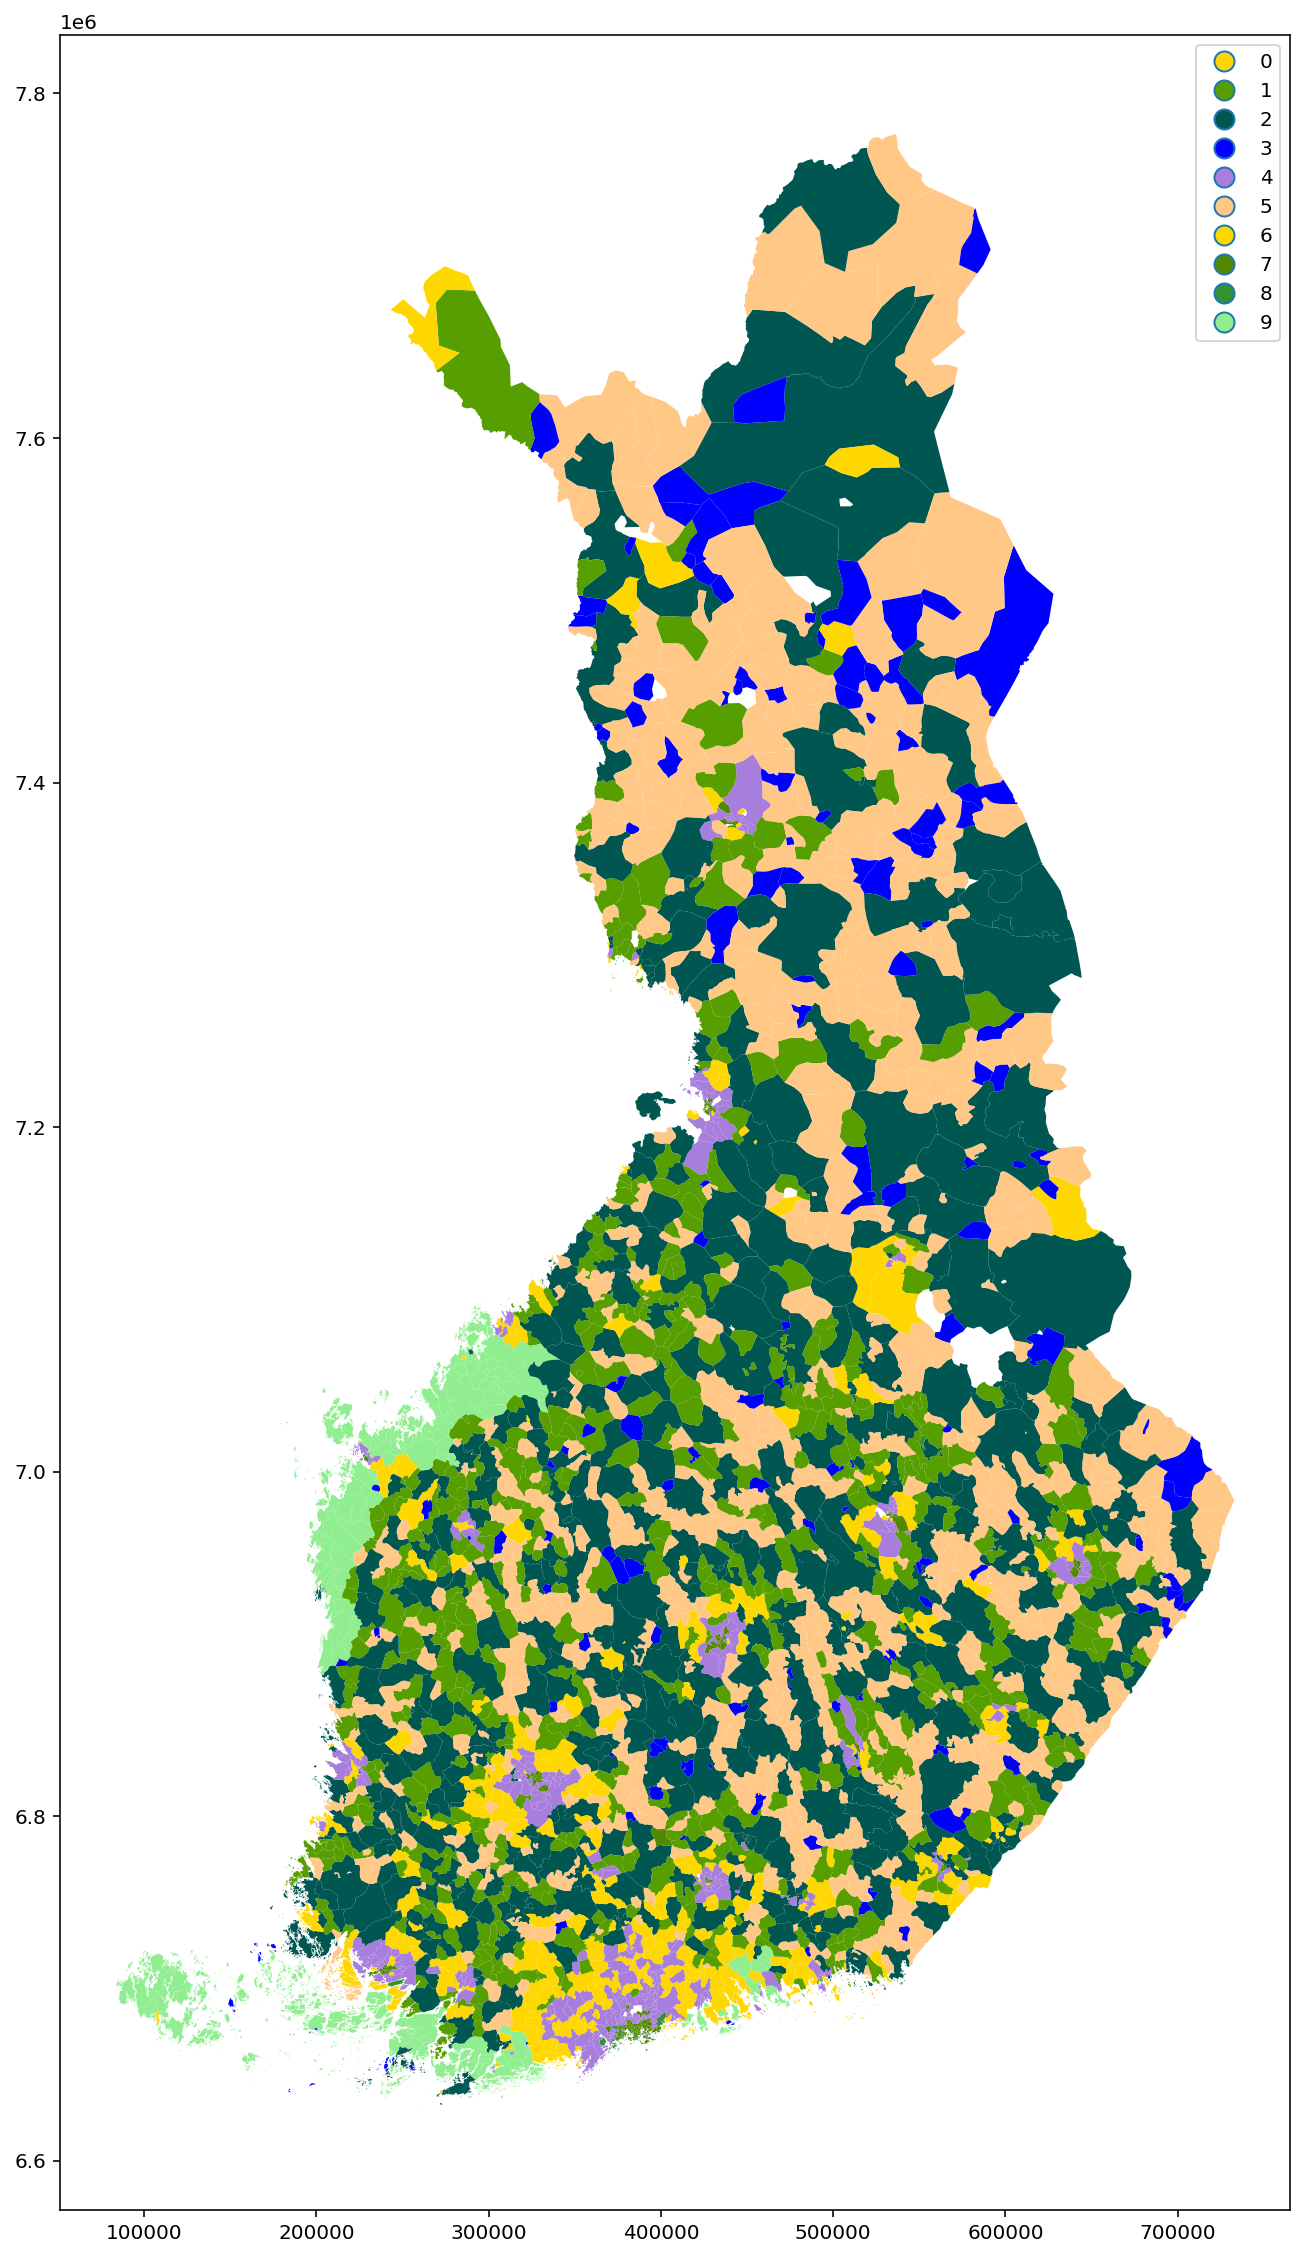

In [8]:
import geopandas
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('my cmap', ['gold', 'green', 'blue', 'pink', 'gold', 'darkgreen', 'lightgreen'])
draw = geopandas.GeoDataFrame(pd.DataFrame(data[['cluster', 'geometry']], dtype=object),geometry='geometry')
draw.plot(column='cluster', cmap=cmap, legend=True, figsize=(20,20))

In [9]:
import xgboost as xgb
from sklearn.feature_selection import  mutual_info_classif
from create_prediction import create_prediction

target = 'cluster'

ennustettu = "uusi" + target

#Check
#k_selected need to have correct values, if they are too large, evrything needs to be started again
k_selected = 'all'

test_size = 0.2

#Scalers attributes
kbest_score_func = mutual_info_classif
#set values to model configuration attributes

num_class = len(data['cluster'].unique()) #how many classes we are working with

metric = 'merror'
Skfold=True
Verbose = False
testing=True

params = {
    # Parameters that we are going to tune.
    'objective':'multi:softmax',
    'num_class' : num_class,
    'booster' : 'gbtree',
    'eval_metric' : metric
} 

data, test, features_df, importance_df, model, params, dtest, X_train, y_train, X_test, y_test = create_prediction(data, data, target, kbest_score_func, metric, params, numeric_features, categorical_features, scaled=False, testing=testing)


[0]	train-merror:0.06481	test-merror:0.16835
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 10 rounds.
Stopping. Best iteration:
[11]	train-merror:0.00673	test-merror:0.09764

testing
Start with xgb.cv params: merror: 0.09974733333333334
Best xgb.cv params: max_depth 4, min_child_weight 1, merror: 0.09090933333333334
Best xgb.cv params: gamma 0.0, merror: 0.09090933333333334
Best xgb.cv params: lambda 0.0, alpha 0.2, merror: 0.08964633333333333
Best xgb.cv params: colsample_bytree 1.0, subsample 1.0, merror: 0.08964633333333333
Best xgb.cv params: eta 0.2, merror: 0.09217166666666667
Best xgb.cv params: max_depth 3, min_child_weight 3, merror: 0.08838366666666668
Best xgb.cv params: gamma 0.0, merror: 0.08838366666666668
Best xgb.cv params: lambda 0.0, alpha 0.2, merror: 0.08838366666666668
Best xgb.cv params: colsample_bytree 1.0, subsample 1.0, merror: 0.08838366666666668
Best xgb.cv params: eta 

In [27]:
from shap_tree import shap_tree
explainer, shap_values, shap_interaction_values, shap_expected_value  = shap_tree(X, data[target], params)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


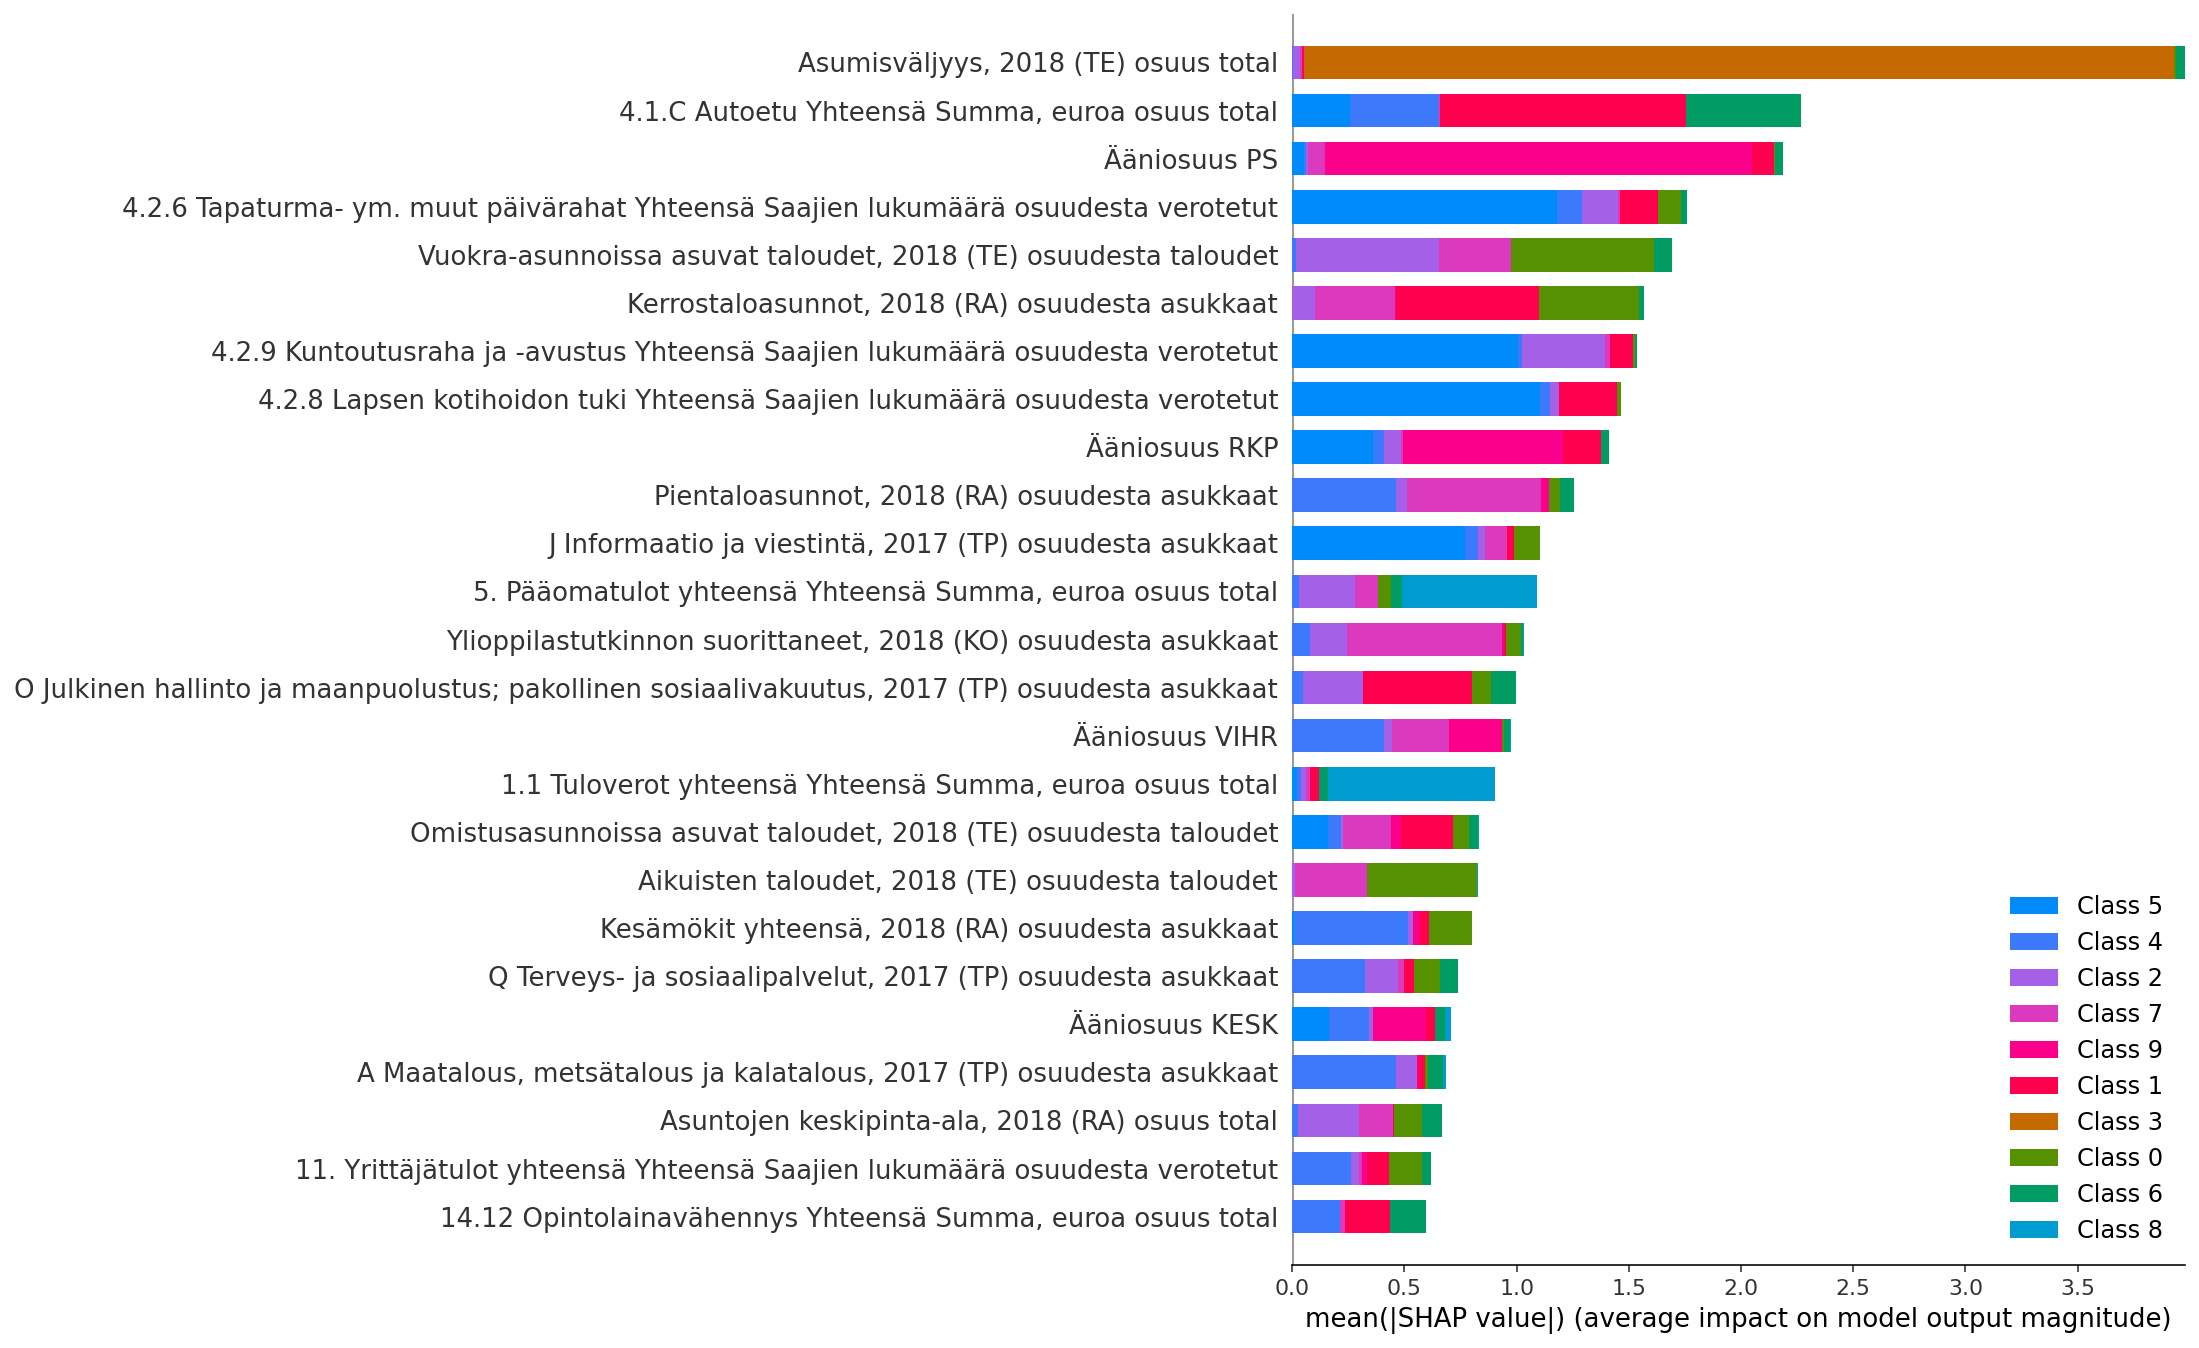

In [28]:
import shap
test=shap.summary_plot(shap_values, X,  max_display=25)

invalid value encountered in true_divide
invalid value encountered in true_divide


Klusterin koko  439


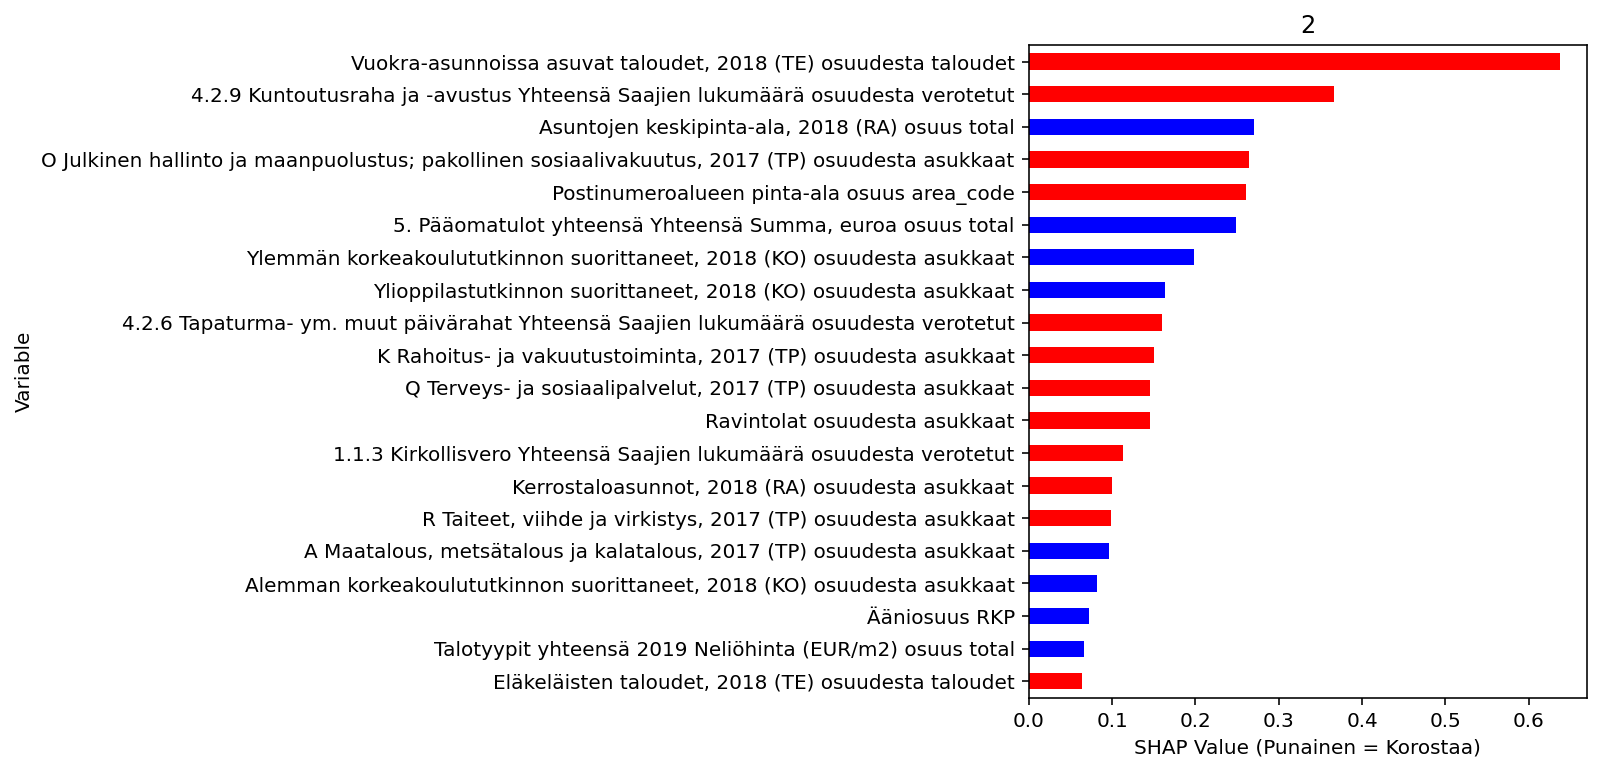

In [29]:
idx=2
from shap_vals import shap_vals
k =shap_vals(X, shap_values[idx])
k2 =k.tail(20)
colorlist = k2['Sign']
ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, title= idx, figsize=(5,6),legend=False)
ax.set_xlabel("SHAP Value (Punainen = Korostaa)")
print('Klusterin koko ', len(data[data['cluster']==idx]))


In [30]:
from OrderedSet import OrderedSet
k= []
i=0
for t in data[target].unique():
    vals = shap_vals(X, shap_values[i])
    k.extend(vals['Variable'].tail(1).to_list())
    i = i + 1
k = list(dict.fromkeys(k))
new = ['Postinumero','muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_x = list(OrderedSet(X.columns.to_list())- (OrderedSet(X.columns.to_list())-OrderedSet(k)))
new_df=pd.concat([data[new],X[new_x]], axis=1)

In [31]:
show_df = new_df[new_df['Suurin_puolue']=='RKP'].sample(n=5).copy()
from IPython.display import HTML
import numpy as np
show_df = np.round(show_df,2)
HTML(show_df.to_html(index=False))

Postinumero,muncipality_name,"Asukkaat yhteensä, 2018 (HE)",Suurin_puolue,"Asumisväljyys, 2018 (TE) osuus total","Ylioppilastutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat","Kesämökit yhteensä, 2018 (RA) osuudesta asukkaat","Vuokra-asunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet",4.2.6 Tapaturma- ym. muut päivärahat Yhteensä Saajien lukumäärä osuudesta verotetut,"1.1 Tuloverot yhteensä Yhteensä Summa, euroa osuus total","4.1.C Autoetu Yhteensä Summa, euroa osuus total",Ääniosuus PS
22150,Jomala,1937.0,RKP,0.15,0.18,-0.51,0.16,0.65,-0.05,-0.14,-2.87
66830,Vöyri,471.0,RKP,0.32,-0.04,-0.36,-0.17,-0.69,-0.39,-0.50,-2.52
22220,Finström,393.0,RKP,0.42,-0.72,-0.10,-0.33,-0.69,0.61,-0.50,-2.87
66840,Uusikaarlepyy,339.0,RKP,0.27,-0.65,-0.53,-0.44,-0.69,0.03,-0.50,-2.79
64210,Närpes,429.0,RKP,0.55,-0.10,-0.07,-0.76,1.12,-0.02,-0.50,-2.75
